In [81]:
# libraries

import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

In [79]:
# We might not need player_data.csv and players.csv since they are personal information that we can not make use of
salary_20 = pd.read_csv("salary_0020.csv")
salary_17 = pd.read_csv("salary_1718.csv")
stats = pd.read_csv("1950/seasons_stats.csv")
stats = stats.drop(stats.columns[0], axis=1)
pd.set_option('display.max_columns', None)


# Append salary to the dataframe
# Use the following attributes to fit models
# age, G, GS, MP, PER, TS, FTr, ORB%, DRB%, TRB%, AST%  STL%  BLK% TOV%  USG%, OWS  DWS, WS  WS/48, VORP, OBPM  DBPM  BPM and everything afterwards

team_names = {
    "Atlanta Hawks":"ATL",
    "Boston Celtics":"BOS",
    "Brooklyn Nets":"BKN",
    "Charlotte Hornets":"CHA",
    "Charlotte Bobcats":"CHB",
    "Chicago Bulls":"CHI",
    "Cleveland Cavaliers":"CLE",
    "Dallas Mavericks":"DAL",
    "Denver Nuggets":"DEN",
    "Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
    "Houston Rockets":"HOU",
    "Indiana Pacers":"IND",
    "LA Clippers":"LAC",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers":"LAL",
    "Memphis Grizzlies":"MEM",
    "Miami Heat":"MIA",
    "Milwaukee Bucks":"MIL",
    "Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
    "Oklahoma City Thunder":"OKC",
    "Orlando Magic":"ORL",
    "Philadelphia 76ers":"PHI",
    "Phoenix Suns":"PHX",
    "Portland Trail Blazers":"POR",
    "Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
    "Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
    "Washington Wizards":"WAS",
    "Seattle SuperSonics":"SEA",
    "Vancouver Grizzlies":"VAN",
    "New Jersey Nets":"NJN",
    "New Orleans Hornets":"NOK",
}

unknowns = [
    'Madrid Real Madrid',
    "null Unknown",
    "NO/Oklahoma City Hornets",
    'Bilbao Basket Bilbao Basket',
    "Fenerbahce Ulker Fenerbahce Ulker",
    "Maccabi Haifa Maccabi Haifa"
]

# Convert team names in 0020 dataset to abbreviations
for i in range(len(salary_20)):
    v = salary_20['team'][i]
    if v in unknowns:
        continue
    salary_20.loc[i,'team'] = team_names[v]

# Remove unknowns
for v in unknowns:
    salary_20 = salary_20[salary_20['team'] != v]

# Only use players from 2000 onward
stats = stats[stats['Year'] >= 2000]

# Add salary to stats dataset based on player, year
merged_00_to_17 = stats.merge(salary_20, left_on=['Year', 'Player', 'Tm'], right_on=['season', 'name', 'team'])

# Drop unused columns that we think are irrelevant from merged dataset
merged_00_to_17 = merged_00_to_17.drop(columns = ['Pos', 'Tm', '3PAr', 'blanl', 'blank2', 'rank', 'position', 'team', 'name', 'season'])

# display(salary_20.head(10))

# display(stats.head(10))

# display(merged_00_to_17.head(10))

# display(merged_00_to_17.tail(10))

# Different datasets to see what produces best predictions
# Can either always predict later year or split train, test throughout years

merged_10_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2010]

merged_13_to_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2013]

# Using 16 to predict 17

merged_16_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2016]

# Split within year

merged_17 = merged_00_to_17[merged_00_to_17['Year'] >= 2017]



<Axes: >

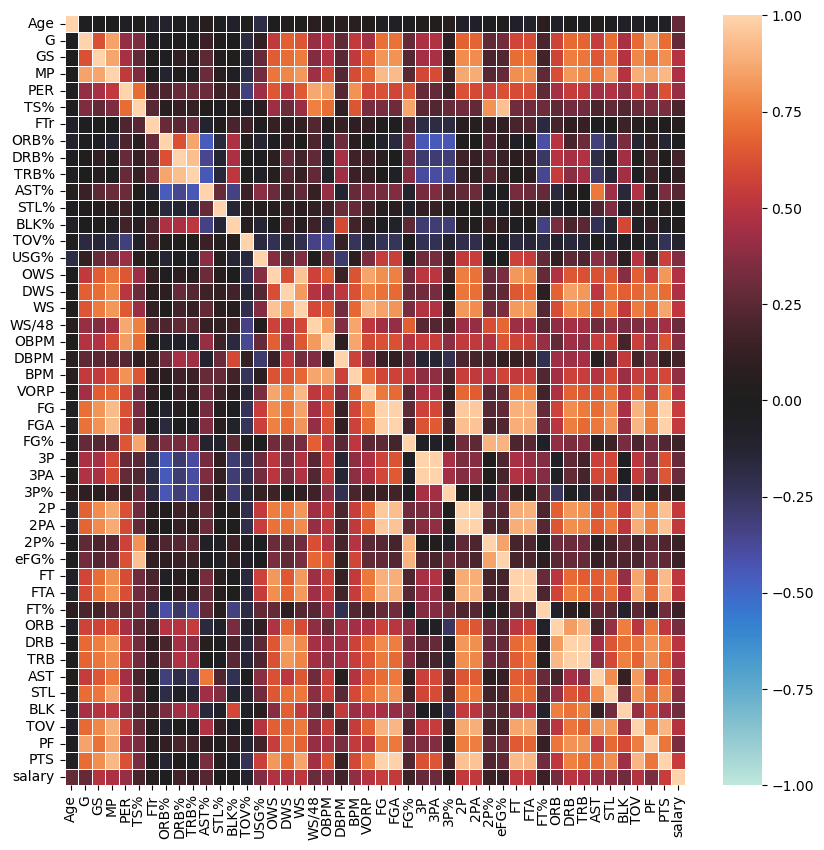

In [82]:
# heatmap for correlation
fig, ax = plt.subplots(figsize=(10, 10))

sb.heatmap(merged_00_to_17.drop(['Player', 'Year'], axis = 1).corr(), vmin=-1, vmax=1, center= 0, linewidths=.5, xticklabels=True, yticklabels=True)

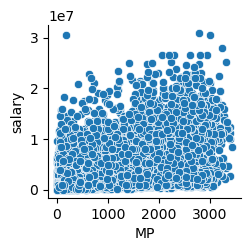

In [83]:
sb.pairplot(merged_00_to_17, x_vars = ["MP"], y_vars = ['salary'])
plt.show()